## Standard import

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def reReadData():
  df=pd.read_csv('gdrive/My Drive/master_ds_v6.csv',header=0, index_col=0, 
                infer_datetime_format=True, parse_dates=['Date'])
  df['log_ret'] = np.log(df['Russell3000_Adj_Close']) - np.log(df['Russell3000_Adj_Close'].shift(1))
  return df


def plotProb_train(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_train.index, df_train['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_train.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def plotProb_test(model):
  bear_regime = 0 if model.params['const[0]']<model.params['const[1]'] else 1

  fig, axes = plt.subplots(2, figsize=(15, 15))

  ax = axes[0]
  ax.plot(df_test.index, df_test['Russell_Close'])
  ax.set(title='Russell_Close')
  
  ax = axes[1]
  ax.plot(df_test.index, model.filtered_marginal_probabilities[bear_regime])
  ax.set(title='Filtered probability of bear_regime')

  plt.show()


def labeling(model,threshold1, threshold2):
  bear_regime = 0 if model.params['const[0]'] < model.params['const[1]'] else 1

  label_filtered = []
  
  for i in model.filtered_marginal_probabilities[bear_regime].values:
    if i >= threshold1:
      app = -1
    elif i >= threshold2:
      app = 0
    else:
      app = 1
    label_filtered.append(app)

  label_filtered= np.array(label_filtered)
  
  return label_filtered


def duration(label):

  duration_bull = []
  duration_static = []
  duration_bear = []

  count,prev,trade = 1,1,0

  for i in label:
    if i == prev:
      count+=1
    else:
      trade+=1
      if prev == 1:
        duration_bull.append(count)
        count = 1
      elif prev == 0:
        duration_static.append(count)
        count = 1
      else:
        duration_bear.append(count)
        count = 1
    prev = i
    
  if prev == 1:
    duration_bull.append(count)
  elif prev == 0:
    duration_static.append(count)
  else:
    duration_bear.append(count)

  duration_bull = pd.DataFrame(duration_bull)
  duration_static = pd.DataFrame(duration_static)
  duration_bear = pd.DataFrame(duration_bear)

  return duration_bull, duration_static, duration_bear,trade


def label_train_logret(label):
  return (df_train['log_ret'] * label).sum()

def label_test_logret(label):
  return (df_test['log_ret'] * label).sum()



def Search_train(model, duration_static, duration_bear):
  threshold1, threshold2, record =0,0,0
  for i in range(1,101):
    for j in range(i):
      label_filtered = labeling(model,i/100, j/100)
      if ( (duration(label_filtered))[1].mean().values >= duration_static ):
        if ( (duration(label_filtered))[2].mean().values >= duration_bear ) :
          if ( (df_train['log_ret'] * label_filtered).sum() >= record ):
            threshold1, threshold2, record = i,j,(df_train['log_ret'] * label_filtered).sum()
  return threshold1/100, threshold2/100

## Set parameters

In [ ]:
duration_static, duration_bear = 2, 4

In [ ]:
# training set and validation+testing set
train_start = '2000-01-01'
train_end = '2013-12-31'
test_start = '2014-01-01'
test_end = '2022-01-25'

## Read Data

In [ ]:
df = reReadData()
print(df)

             PX_LAST     PX_VOLUME  ...  Russell3000_Volume   log_ret
Date                                ...                              
1990-01-02    585.41           NaN  ...                 0.0       NaN
1990-01-03    585.05           NaN  ...                 0.0 -0.000999
1990-01-04    580.97           NaN  ...                 0.0 -0.006316
1990-01-05    575.74           NaN  ...                 0.0 -0.010058
1990-01-08    577.78           NaN  ...                 0.0  0.003448
...              ...           ...  ...                 ...       ...
2022-01-19  14547.22  1.322548e+09  ...                 0.0 -0.010180
2022-01-20  14378.11  1.355285e+09  ...                 0.0 -0.011763
2022-01-21  14099.17  1.917342e+09  ...                 0.0 -0.019599
2022-01-24  14173.27  2.178968e+09  ...                 0.0  0.000000
2022-01-25  13982.41  1.611222e+09  ...                 0.0  0.000000

[8090 rows x 45 columns]


## Construct MA and EMA columns

In [ ]:
for k in [5,10,15]:
  name = 'log_ret_MA'+str(k)
  df[name] = df['log_ret'].rolling(k).mean()
  name1 = 'log_ret_EWMA'+str(k)
  df[name1] = df['log_ret'].ewm(span=k).mean()  
df

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret,log_ret_MA5,log_ret_EWMA5,log_ret_MA10,log_ret_EWMA10,log_ret_MA15,log_ret_EWMA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-02,585.41,NaN,NaN,7.83,7.50,7.81,7.90,7.87,7.94,8.00,0.11,0.07,8.38000,0.80,8.54,22.89,0.0490,22.89,0.0490,158.6294,-0.8405,69.0585,190.157,17.2194,2.3009,0.3,0.0,5.4,0.0,276.0,0.0,17.240000,0.8,0.0,NaN,NaN,359.69,1.620700e+08,1.44,-0.68,-0.07,0.026,200.309998,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,585.05,NaN,NaN,7.89,7.53,7.85,7.96,7.92,7.99,8.04,0.10,0.05,8.38000,0.75,8.37,23.68,0.0345,23.68,0.0345,166.5505,-6.7745,68.4778,190.767,18.4101,3.0652,0.3,0.0,5.4,0.0,276.0,0.0,18.190001,0.8,0.0,NaN,NaN,358.76,1.923300e+08,-0.06,0.74,-0.26,0.026,200.110001,0.0,-0.000999,NaN,-0.000999,NaN,-0.000999,NaN,-0.000999
1990-01-04,580.97,NaN,NaN,7.84,7.50,7.82,7.93,7.91,7.98,8.04,0.14,0.06,8.38000,0.79,8.29,23.41,-0.0114,23.41,-0.0114,104.2355,-19.9820,61.8875,191.575,18.1196,1.8271,0.3,0.0,5.4,0.0,276.0,0.0,19.219999,0.8,0.0,NaN,NaN,355.67,1.770000e+08,-0.71,0.42,-0.22,0.026,198.850006,0.0,-0.006316,NaN,-0.004189,NaN,-0.003924,NaN,-0.003835
1990-01-05,575.74,NaN,NaN,7.79,7.46,7.79,7.94,7.92,7.99,8.06,0.20,0.09,8.38000,0.84,8.20,23.08,-0.0141,23.08,-0.0141,56.8323,-36.1185,54.9317,192.319,17.4400,-0.2747,0.3,0.0,5.4,0.0,84.0,1.0,20.110001,0.8,0.0,NaN,NaN,352.20,1.585300e+08,-0.85,0.77,-0.21,0.026,196.860001,0.0,-0.010058,NaN,-0.006969,NaN,-0.006390,NaN,-0.006192
1990-01-08,577.78,NaN,NaN,7.79,7.49,7.81,7.95,7.92,8.02,8.09,0.23,0.12,8.38000,0.84,8.27,21.62,-0.0633,21.62,-0.0633,43.9596,-30.0539,56.8927,193.003,16.6146,-0.5619,0.3,0.0,5.4,0.0,84.0,0.0,20.260000,0.8,0.0,NaN,NaN,353.79,1.401100e+08,0.30,-0.41,-0.26,0.026,197.539993,0.0,0.003448,NaN,-0.002642,NaN,-0.003148,NaN,-0.003280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-19,14547.22,1.322548e+09,0.05,0.17,0.36,0.57,1.33,1.62,1.83,2.14,1.66,0.79,0.25514,0.09,0.08,86.96,0.0179,85.58,-0.0135,-167.3056,-99.3827,32.9727,2780.178,21.6253,-124.8524,0.5,0.0,3.9,0.0,199.0,0.0,23.850000,2.3,0.0,451.750000,109357600.0,4532.76,3.387370e+09,-0.31,0.06,0.53,0.000,2633.860107,0.0,-0.010180,-0.008528,-0.008960,-0.006132,-0.006185,-0.004039,-0.004643
2022-01-20,14378.11,1.355285e+09,0.05,0.17,0.36,0.60,1.34,1.62,1.83,2.14,1.66,0.75,0.25886,0.08,0.08,86.90,-0.0007,84.67,-0.0106,-163.7336,-98.8126,29.7787,2768.382,23.3995,-171.7405,0.5,0.0,3.9,0.0,199.0,0.0,25.590000,2.3,0.0,446.750000,122379700.0,4482.73,3.473060e+09,-0.31,0.06,0.53,0.000,2603.060059,0.0,-0.011763,-0.011175,-0.009894,-0.005103,-0.007199,-0.004907,-0.005533
2022-01-21,14099.17,1.917342e+09,0.05,0.17,0.35,0.58,1.28,1.54,1.75,2.07,1.58,0.74,0.25771,0.09,0.08,85.14,-0.0203,85.43,0.0090,-191.9934,-99.7294,25.4267,2751.593,25.6026,-213.5388,0.5,0.0,3.9,0.0,199.0,0.0,28.850000,2.3,0.0,437.980011,202271200.0,4397.94,3.945810e+09,-0.31,0.06,0.53,0.000,2552.540039,0.0,-0.019599,-0.012187,-0.013129,-0.007058,-0.009453,-0.006071,-0.007291


In [ ]:
df = df.iloc[15: , :]

## Split training and testing sets

In [ ]:
df = df[train_start:test_end]
df_train, df_test = df[train_start:train_end],df[test_start:test_end]
print(df,df_train,df_test)

             PX_LAST     PX_VOLUME  ...  log_ret_MA15  log_ret_EWMA15
Date                                ...                              
2000-01-03   2909.89  1.748611e+09  ...      0.001836        0.001467
2000-01-04   2795.36  1.805332e+09  ...     -0.000677       -0.003646
2000-01-05   2802.51  2.100967e+09  ...      0.000168       -0.002977
2000-01-06   2784.07  1.972651e+09  ...     -0.000207       -0.002664
2000-01-07   2878.11  2.151953e+09  ...      0.001289        0.001013
...              ...           ...  ...           ...             ...
2022-01-19  14547.22  1.322548e+09  ...     -0.004039       -0.004643
2022-01-20  14378.11  1.355285e+09  ...     -0.004907       -0.005533
2022-01-21  14099.17  1.917342e+09  ...     -0.006071       -0.007291
2022-01-24  14173.27  2.178968e+09  ...     -0.005886       -0.006380
2022-01-25  13982.41  1.611222e+09  ...     -0.006286       -0.005582

[5558 rows x 51 columns]             PX_LAST     PX_VOLUME  ...  log_ret_MA15  log_ret_EW

In [ ]:
# negative skewed and fat tails
from scipy.stats import skew, kurtosis
print(skew(df_train['log_ret']),kurtosis(df_train['log_ret']))

-0.218932236251712 7.210896529791372


## The dataframe used to output the labels

In [ ]:
df_output = pd.DataFrame(data = df['log_ret'],index = df.index)
df_output

,log_ret
Date,
2000-01-03,-0.009003
2000-01-04,-0.039434
2000-01-05,0.001705
2000-01-06,-0.000476
2000-01-07,0.026756
...,...
2022-01-19,-0.010180
2022-01-20,-0.011763
2022-01-21,-0.019599


## HMM1(log-return)

In [ ]:
hmm1 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c',switching_variance=True)
hmm1_results = hmm1.fit(search_reps = 100)
print(hmm1_results.summary())

t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
label_filtered_result = labeling(hmm1_results,t1,t2)
print((duration(label_filtered_result))[0].mean())
print((duration(label_filtered_result))[1].mean())
print((duration(label_filtered_result))[2].mean())
print((duration(label_filtered_result))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
print(np.histogram(label_filtered_result))

# Set maxiter to 0 to simply update the filter probability
# Intentionally stop the optimization before convergence, so the warning can be ignored
hmm1_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',switching_variance=True)
hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

label_filtered_test = labeling(hmm1_test_results,t1,t2)
print((duration(label_filtered_test))[0].mean())
print((duration(label_filtered_test))[1].mean())
print((duration(label_filtered_test))[2].mean())
print((duration(label_filtered_test))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
print(np.histogram(label_filtered_test))

name3 = 'hmm1'
label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
df_output[name3] = label_concat

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               10862.262
Date:                Mon, 28 Feb 2022   AIC                         -21712.524
Time:                        07:11:48   BIC                         -21675.515
Sample:                             0   HQIC                        -21699.321
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.665      0.096      -0.002       0.000
sigma2         0.0004   2.32e-05     18.516      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## HMM1(MA5), HMM1(MA10), HMM1(MA15)

In [ ]:
for k in [5,10,15]:

  name = 'log_ret_MA'+str(k)
  hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_results = hmm1.fit(search_reps = 100)
  print(hmm1_results.summary())

  t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm1_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))


  # Set maxiter to 0 to simply update the filter probability
  # Intentionally stop the optimization before convergence, so the warning can be ignored
  hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm1_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))


  name3 = 'hmm1_MA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat
  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               14099.003
Date:                Mon, 28 Feb 2022   AIC                         -28186.007
Time:                        07:12:30   BIC                         -28148.997
Sample:                             0   HQIC                        -28172.804
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.000     -6.935      0.000      -0.002      -0.001
sigma2      5.814e-05   2.85e-06     20.389      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    11.571429
dtype: float64
0    3.570533
dtype: float64
0    4.156757
dtype: float64
643
0.3343595384362077 3.150845120686208
(array([ 769,    0,    0,    0,    0, 1139,    0,    0,    0, 1619]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    16.12987
dtype: float64
0    2.92638
dtype: float64
0    3.329787
dtype: float64
333
0.8342706349714035 1.564267934521835
(array([ 313,    0,    0,    0,    0,  477,    0,    0,    0, 1241]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               15753.656
Date:                Mon, 28 Feb 2022   AIC                         -31495.313
Time:                        07:12:58   BIC                         -31458.303
Sample:                             0   HQIC                        -31482.110
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   6.33e-05     21.076      0.000       0.001       0.001
sigma2      2.859e-06    1.8e-07     15.853      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    20.04
dtype: float64
0    2.064378
dtype: float64
0    4.044776
dtype: float64
491
0.3343595384362077 3.7253989016540396
(array([ 542,    0,    0,    0,    0,  481,    0,    0,    0, 2504]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    27.048387
dtype: float64
0    1.77907
dtype: float64
0    4.04
dtype: float64
197
0.8342706349714035 1.7726971151654336
(array([ 202,    0,    0,    0,    0,  153,    0,    0,    0, 1676]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               16719.891
Date:                Mon, 28 Feb 2022   AIC                         -33427.781
Time:                        07:13:25   BIC                         -33390.772
Sample:                             0   HQIC                        -33414.578
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -17.079      0.000      -0.002      -0.002
sigma2      1.231e-05   5.78e-07     21.292      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## HMM1(EWMA5), HMM1(EWMA10), HMM1(EWMA15)

In [ ]:
for k in [5,10,15]:

  name = 'log_ret_EWMA'+str(k)
  hmm1 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_results = hmm1.fit(search_reps = 100)
  print(hmm1_results.summary())

  t1,t2 = Search_train(hmm1_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm1_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))

  # Set maxiter to 0 to simply update the filter probability
  # Intentionally stop the optimization before convergence, so the warning can be ignored
  hmm1_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',switching_variance=True)
  hmm1_test_results = hmm1_test.fit(start_params = hmm1_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm1_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))

  name3 = 'hmm1_EWMA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat
  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:          log_ret_EWMA5   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               14022.026
Date:                Mon, 28 Feb 2022   AIC                         -28032.052
Time:                        07:13:52   BIC                         -27995.043
Sample:                             0   HQIC                        -28018.849
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012   9.41e-05     12.845      0.000       0.001       0.001
sigma2      8.507e-06    4.6e-07     18.494      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    15.934783
dtype: float64
0    2.132616
dtype: float64
0    4.100559
dtype: float64
595
0.3343595384362077 4.301171270031514
(array([ 734,    0,    0,    0,    0,  595,    0,    0,    0, 2198]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    16.391304
dtype: float64
0    1.706667
dtype: float64
0    2.734694
dtype: float64
339
0.8342706349714035 3.239271223975046
(array([ 268,    0,    0,    0,    0,  256,    0,    0,    0, 1507]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA10   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               15587.577
Date:                Mon, 28 Feb 2022   AIC                         -31163.155
Time:                        07:14:20   BIC                         -31126.145
Sample:                             0   HQIC                        -31149.952
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.000    -13.246      0.000      -0.003      -0.002
sigma2       2.33e-05   1.13e-06     20.625      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    12.36478
dtype: float64
0    2.559006
dtype: float64
0    4.122905
dtype: float64
659
0.3343595384362077 6.306396273444882
(array([ 738,    0,    0,    0,    0,  824,    0,    0,    0, 1965]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))
0    19.527027
dtype: float64
0    2.485294
dtype: float64
0    3.364865
dtype: float64
283
0.8342706349714035 3.1385670497449025
(array([ 249,    0,    0,    0,    0,  338,    0,    0,    0, 1444]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               16549.034
Date:                Mon, 28 Feb 2022   AIC                         -33086.068
Time:                        07:14:47   BIC                         -33049.059
Sample:                             0   HQIC                        -33072.865
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.000     -9.871      0.000      -0.003      -0.002
sigma2      1.027e-05   1.17e-06      8.772      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
df_output

,log_ret,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15
Date,,,,,,,,
2000-01-03,-0.009003,-1,0,1,1,1,1,1
2000-01-04,-0.039434,-1,-1,1,1,-1,-1,0
2000-01-05,0.001705,-1,-1,1,1,-1,-1,-1
2000-01-06,-0.000476,-1,-1,1,1,-1,-1,-1
2000-01-07,0.026756,-1,-1,1,1,-1,0,1
...,...,...,...,...,...,...,...,...
2022-01-19,-0.010180,-1,-1,-1,-1,-1,-1,-1
2022-01-20,-0.011763,-1,-1,-1,-1,-1,-1,-1
2022-01-21,-0.019599,-1,-1,-1,-1,-1,-1,-1


## Construct state duration

In [ ]:
model = 'hmm1'

duration_bear = duration_static = duration_bull = 0
duration_bear_list = []
duration_static_list = [] 
duration_bull_list = []

for i in range(len(df_output[model])):
  if df_output[model].iloc[i] == -1:
    duration_bull = 0
    duration_static = 0
    duration_bear+=1 
  elif df_output[model].iloc[i] == 0:
    duration_bull = 0
    duration_bear = 0
    duration_static+=1
  else:
    duration_bear = 0
    duration_static = 0
    duration_bull+=1

  duration_bear_list.append(duration_bear)
  duration_static_list.append(duration_static)
  duration_bull_list.append(duration_bull)

duration_bear_array = np.array(duration_bear_list)
duration_static_array = np.array(duration_static_list)
duration_bull_array = np.array(duration_bull_list)

name1, name2, name3 = model+'_duration_bear', model+'_duration_static', model+'_duration_bull'
df_output[name1],df_output[name2],df_output[name3] = duration_bear_array,duration_static_array,duration_bull_array


In [ ]:
df_output[['hmm1',name1,name2,name3]].tail(30)

,hmm1,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull
Date,,,,
2021-12-13,-1,12,0,0
2021-12-14,-1,13,0,0
2021-12-15,-1,14,0,0
2021-12-16,-1,15,0,0
2021-12-17,-1,16,0,0
2021-12-20,-1,17,0,0
2021-12-21,-1,18,0,0
2021-12-22,-1,19,0,0
2021-12-23,-1,20,0,0


In [ ]:
for model in ['hmm1_MA5',	'hmm1_MA10',	'hmm1_MA15',	'hmm1_EWMA5',
              'hmm1_EWMA10',	'hmm1_EWMA15']:

  duration_bear = duration_static = duration_bull = 0
  duration_bear_list = []
  duration_static_list = [] 
  duration_bull_list = []

  for i in range(len(df_output[model])):
    if df_output[model].iloc[i] == -1:
      duration_bull = duration_static = 0
      duration_bear+=1 
    elif df_output[model].iloc[i] == 0:
      duration_bull = duration_bear = 0
      duration_static+=1
    else:
      duration_bear = 0
      duration_static = 0
      duration_bull+=1

    duration_bear_list.append(duration_bear)
    duration_static_list.append(duration_static)
    duration_bull_list.append(duration_bull)

  duration_bear_array = np.array(duration_bear_list)
  duration_static_array = np.array(duration_static_list)
  duration_bull_array = np.array(duration_bull_list)

  name1, name2, name3 = model+'_duration_bear', model+'_duration_static', model+'_duration_bull'
  df_output[name1],df_output[name2],df_output[name3] = duration_bear_array,duration_static_array,duration_bull_array

## PCA due to multicollinearity

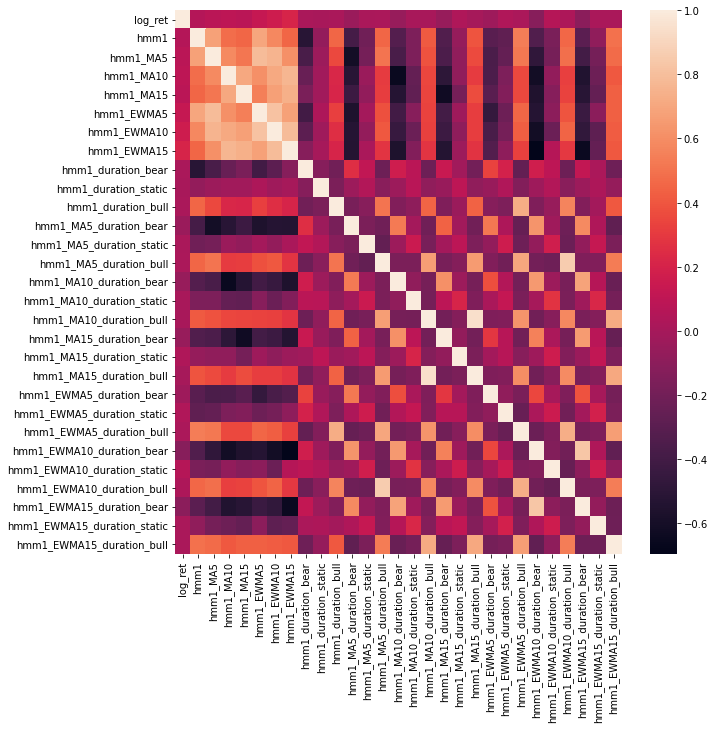

In [ ]:
# multicollinearity

import seaborn as sns
%matplotlib inline

Var_Corr = df_output.corr()

# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)

In [ ]:
df_train

,PX_LAST,PX_VOLUME,T1M,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret,log_ret_MA5,log_ret_EWMA5,log_ret_MA10,log_ret_EWMA10,log_ret_MA15,log_ret_EWMA15
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,NaN,5.48,5.55,6.09,6.42,6.50,6.58,6.61,1.10,0.20,6.00,0.93,5.43,25.60,0.0000,25.60,0.0000,61.0066,-25.0882,64.4827,767.411,23.8369,19.9789,0.2,0.0,4.1,0.0,289.0,0.0,24.209999,5.4,0.0,96.855034,8164300.0,1455.22,9.318000e+08,-0.71,0.62,-1.42,0.021,786.200012,0.0,-0.009003,0.000688,-0.000822,0.002867,0.001006,0.001836,0.001467
2000-01-04,2795.36,1.805332e+09,NaN,5.43,5.50,6.00,6.34,6.40,6.49,6.53,1.06,0.19,6.04,0.77,5.38,25.55,-0.0020,25.55,-0.0020,-79.2123,-89.3938,42.2468,798.420,23.5873,-2.9796,0.2,0.0,4.1,0.0,289.0,0.0,27.010000,5.4,0.0,93.067421,8089800.0,1399.42,1.009000e+09,-4.06,0.00,2.07,0.021,755.799988,0.0,-0.039434,-0.007637,-0.013693,-0.000997,-0.006347,-0.000677,-0.003646
2000-01-05,2802.51,2.100967e+09,NaN,5.44,5.49,6.05,6.43,6.51,6.62,6.64,1.18,0.24,6.03,0.75,5.41,24.91,-0.0250,24.91,-0.0250,-141.4229,-74.0882,43.5119,798.420,24.1583,-7.7281,0.2,0.0,4.1,0.0,289.0,0.0,26.410000,5.4,0.0,93.233925,12177900.0,1402.11,1.085500e+09,-0.09,0.20,0.16,0.021,757.090027,0.0,0.001705,-0.008487,-0.008560,-0.002020,-0.004883,0.000168,-0.002977
2000-01-06,2784.07,1.972651e+09,NaN,5.41,5.44,6.03,6.39,6.46,6.57,6.58,1.16,0.22,6.03,0.78,5.54,24.78,-0.0052,24.78,-0.0052,-120.0770,-83.3148,40.8646,796.196,24.6886,-11.5460,0.2,0.0,4.1,0.0,289.0,0.0,25.730000,5.4,0.0,91.735512,6227200.0,1403.45,1.092300e+09,-0.73,-0.44,1.26,0.021,756.729980,0.0,-0.000476,-0.008653,-0.005865,-0.002353,-0.004082,-0.000207,-0.002664
2000-01-07,2878.11,2.151953e+09,NaN,5.38,5.42,6.00,6.35,6.42,6.52,6.55,1.14,0.21,6.03,0.81,5.61,24.22,-0.0226,24.22,-0.0226,-39.8800,-37.6259,55.3509,794.061,23.5503,0.1234,0.2,0.0,4.1,0.0,306.0,1.0,21.719999,5.4,0.0,97.063110,8066500.0,1441.47,1.225200e+09,3.21,-0.48,-1.43,0.021,777.250000,0.0,0.026756,-0.004090,0.005008,-0.001072,0.001525,0.001289,0.001013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24,5242.67,3.694230e+08,0.01,0.07,0.09,0.14,0.80,1.73,2.99,3.90,2.92,2.61,0.25,0.18,0.08,99.22,0.0031,99.24,0.0053,152.2677,-0.0932,67.8914,1063.695,17.3029,20.3261,0.2,0.0,6.9,0.0,264.0,0.0,12.480000,3.2,0.0,157.512558,45368800.0,1833.32,1.307630e+09,0.34,0.10,0.09,0.000,1100.020020,0.0,0.003196,0.005912,0.004159,0.001953,0.003169,0.001570,0.002473
2013-12-26,5264.15,5.674554e+08,0.00,0.07,0.09,0.13,0.81,1.74,3.00,3.92,2.93,2.58,0.25,0.18,0.08,99.55,0.0033,99.64,0.0040,144.0630,-1.3861,69.8553,1066.604,18.8342,23.5364,0.2,0.0,6.9,0.0,264.0,0.0,12.330000,3.2,0.0,158.313324,63365000.0,1842.02,1.982270e+09,0.44,-0.32,-0.31,0.000,1104.520020,0.0,0.004082,0.003607,0.004133,0.003586,0.003335,0.001918,0.002674
2013-12-27,5262.62,5.422317e+08,0.01,0.07,0.09,0.12,0.79,1.74,3.02,3.94,2.95,2.62,0.25,0.18,0.08,100.32,0.0077,100.16,0.0052,118.3252,-5.1543,69.2556,1070.458,20.3387,22.3700,0.2,0.0,6.9,0.0,264.0,0.0,12.460000,3.2,0.0,158.304703,61814000.0,1841.40,2.052920e+09,-0.05,-0.07,0.24,0.000,1103.930054,0.0,-0.000534,0.003823,0.002577,0.003799,0.002632,0.002108,0.002273


In [ ]:
df_train.isna().sum()

PX_LAST                               0
PX_VOLUME                             0
T1M                                 397
T3M                                   0
T6M                                   0
T1Y                                   0
T3Y                                   0
T5Y                                   0
T10Y                                  0
T30Y                                  0
T10Y3M                                0
T10Y2Y                                0
LIBOR_3M                              0
TEDRATE                               0
InterestRate                          0
WTI_Futures_Price                     0
WTI_Futures_Return                    0
WTI_Spot_Price                        0
WTI_Spot_Change                       0
Commdity_channel_index_13             0
Williams_pct_14                       0
RSI_14                                0
Parabolic_0.02_0.2_0.02               0
DMI_14_ADX                            0
Fear_Greedy_Index                     0


In [ ]:
df_train.drop(columns ='T1M').merge(df_output[train_start:train_end],how='outer', left_index=True, right_index=True)

,PX_LAST,PX_VOLUME,T3M,T6M,T1Y,T3Y,T5Y,T10Y,T30Y,T10Y3M,T10Y2Y,LIBOR_3M,TEDRATE,InterestRate,WTI_Futures_Price,WTI_Futures_Return,WTI_Spot_Price,WTI_Spot_Change,Commdity_channel_index_13,Williams_pct_14,RSI_14,Parabolic_0.02_0.2_0.02,DMI_14_ADX,Fear_Greedy_Index,CPI_monthly percent change,CPI_Release,Unemployment_rate,Unemployment_Release,change_in_total_nonfarm_thousand,Nonfarm_Release,VIX_Close,GDP_QOQ_change,GDP_Release,SPY_Adj_Close,SPY_Volume,SP_Adj_Close,SP_Volume,Mkt-RF,SMB,HML,RF,Russell3000_Adj_Close,Russell3000_Volume,log_ret_x,log_ret_MA5,log_ret_EWMA5,log_ret_MA10,log_ret_EWMA10,log_ret_MA15,log_ret_EWMA15,log_ret_y,hmm1,hmm1_MA5,hmm1_MA10,hmm1_MA15,hmm1_EWMA5,hmm1_EWMA10,hmm1_EWMA15,hmm1_duration_bear,hmm1_duration_static,hmm1_duration_bull,hmm1_MA5_duration_bear,hmm1_MA5_duration_static,hmm1_MA5_duration_bull,hmm1_MA10_duration_bear,hmm1_MA10_duration_static,hmm1_MA10_duration_bull,hmm1_MA15_duration_bear,hmm1_MA15_duration_static,hmm1_MA15_duration_bull,hmm1_EWMA5_duration_bear,hmm1_EWMA5_duration_static,hmm1_EWMA5_duration_bull,hmm1_EWMA10_duration_bear,hmm1_EWMA10_duration_static,hmm1_EWMA10_duration_bull,hmm1_EWMA15_duration_bear,hmm1_EWMA15_duration_static,hmm1_EWMA15_duration_bull
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2909.89,1.748611e+09,5.48,5.55,6.09,6.42,6.50,6.58,6.61,1.10,0.20,6.00,0.93,5.43,25.60,0.0000,25.60,0.0000,61.0066,-25.0882,64.4827,767.411,23.8369,19.9789,0.2,0.0,4.1,0.0,289.0,0.0,24.209999,5.4,0.0,96.855034,8164300.0,1455.22,9.318000e+08,-0.71,0.62,-1.42,0.021,786.200012,0.0,-0.009003,0.000688,-0.000822,0.002867,0.001006,0.001836,0.001467,-0.009003,-1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
2000-01-04,2795.36,1.805332e+09,5.43,5.50,6.00,6.34,6.40,6.49,6.53,1.06,0.19,6.04,0.77,5.38,25.55,-0.0020,25.55,-0.0020,-79.2123,-89.3938,42.2468,798.420,23.5873,-2.9796,0.2,0.0,4.1,0.0,289.0,0.0,27.010000,5.4,0.0,93.067421,8089800.0,1399.42,1.009000e+09,-4.06,0.00,2.07,0.021,755.799988,0.0,-0.039434,-0.007637,-0.013693,-0.000997,-0.006347,-0.000677,-0.003646,-0.039434,-1,-1,1,1,-1,-1,0,2,0,0,1,0,0,0,0,2,0,0,2,1,0,0,1,0,0,0,1,0
2000-01-05,2802.51,2.100967e+09,5.44,5.49,6.05,6.43,6.51,6.62,6.64,1.18,0.24,6.03,0.75,5.41,24.91,-0.0250,24.91,-0.0250,-141.4229,-74.0882,43.5119,798.420,24.1583,-7.7281,0.2,0.0,4.1,0.0,289.0,0.0,26.410000,5.4,0.0,93.233925,12177900.0,1402.11,1.085500e+09,-0.09,0.20,0.16,0.021,757.090027,0.0,0.001705,-0.008487,-0.008560,-0.002020,-0.004883,0.000168,-0.002977,0.001705,-1,-1,1,1,-1,-1,-1,3,0,0,2,0,0,0,0,3,0,0,3,2,0,0,2,0,0,1,0,0
2000-01-06,2784.07,1.972651e+09,5.41,5.44,6.03,6.39,6.46,6.57,6.58,1.16,0.22,6.03,0.78,5.54,24.78,-0.0052,24.78,-0.0052,-120.0770,-83.3148,40.8646,796.196,24.6886,-11.5460,0.2,0.0,4.1,0.0,289.0,0.0,25.730000,5.4,0.0,91.735512,6227200.0,1403.45,1.092300e+09,-0.73,-0.44,1.26,0.021,756.729980,0.0,-0.000476,-0.008653,-0.005865,-0.002353,-0.004082,-0.000207,-0.002664,-0.000476,-1,-1,1,1,-1,-1,-1,4,0,0,3,0,0,0,0,4,0,0,4,3,0,0,3,0,0,2,0,0
2000-01-07,2878.11,2.151953e+09,5.38,5.42,6.00,6.35,6.42,6.52,6.55,1.14,0.21,6.03,0.81,5.61,24.22,-0.0226,24.22,-0.0226,-39.8800,-37.6259,55.3509,794.061,23.5503,0.1234,0.2,0.0,4.1,0.0,306.0,1.0,21.719999,5.4,0.0,97.063110,8066500.0,1441.47,1.225200e+09,3.21,-0.48,-1.43,0.021,777.250000,0.0,0.026756,-0.004090,0.005008,-0.001072,0.001525,0.001289,0.001013,0.026756,-1,-1,1,1,-1,0,1,5,0,0,4,0,0,0,0,5,0,0,5,4,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24,5242.67,3.694230e+08,0.07,0.09,0.14,0.80,1.73,2.99,3.90,2.92,2.61,0.25,0.18,0.08,99.22,0.0031,99.24,0.0053,152.2677,-0.0932,67.8914,1063.695,17.3029,20.3261,0.2,0.0,6.9,0.0,264.0,0.0,12.480000,3.2,0.0,157.512558,453688

## HMM2 preprocessing

In [ ]:
# dependent variables used for transition prob.

df_train_tvtp = df_train.drop(columns ='T1M').merge(df_output[train_start:train_end],how='outer', left_index=True, right_index=True)
df_test_tvtp = df_test.drop(columns ='T1M').merge(df_output[test_start:test_end],how='outer', left_index=True, right_index=True)

mean,std = df_train_tvtp.mean(),df_train_tvtp.std()
df_train_tvtp = (df_train_tvtp-df_train_tvtp.mean())/df_train_tvtp.std()
df_train_tvtp['ones'] = 1
df_test_tvtp = (df_test_tvtp-mean)/std
df_test_tvtp['ones'] = 1


In [ ]:
pd.options.mode.use_inf_as_na = True
df_test_tvtp.columns[df_test_tvtp.isna().any()].tolist()

[]

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(df_train_tvtp)
principalDf_train = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])


principalComponents = pca.transform(df_test_tvtp)
principalDf_test = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [ ]:
duration_static, duration_bear = 2, 4

## HMM2(log-return)

In [ ]:
hmm2 = sm.tsa.MarkovRegression(endog=df_train['log_ret'], k_regimes=2,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
hmm2_results = hmm2.fit(search_reps = 100)
print(hmm2_results.summary())

t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
label_filtered_result = labeling(hmm2_results,t1,t2)
print((duration(label_filtered_result))[0].mean())
print((duration(label_filtered_result))[1].mean())
print((duration(label_filtered_result))[2].mean())
print((duration(label_filtered_result))[3])
print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
print(np.histogram(label_filtered_result))

# Set maxiter to 0 to simply update the filter probability
# Intentionally stop the optimization before convergence, so the warning can be ignored
hmm2_test = sm.tsa.MarkovRegression(endog=df_test['log_ret'], k_regimes=2,trend='c',exog_tvtp = principalDf_test,switching_variance=True)
hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

label_filtered_test = labeling(hmm2_test_results,t1,t2)
print((duration(label_filtered_test))[0].mean())
print((duration(label_filtered_test))[1].mean())
print((duration(label_filtered_test))[2].mean())
print((duration(label_filtered_test))[3])
print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
print(np.histogram(label_filtered_test))

name3 = 'hmm2'
label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
df_output[name3] = label_concat

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                log_ret   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               11050.938
Date:                Mon, 28 Feb 2022   AIC                         -22081.875
Time:                        07:15:43   BIC                         -22020.193
Sample:                             0   HQIC                        -22059.870
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000     11.372      0.000       0.002       0.002
sigma2      4.263e-05   1.78e-06     23.911      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    4.380769
dtype: float64
0    1.570122
dtype: float64
0    1.272727
dtype: float64
884
0.8342706349714035 5.604959981445801
(array([ 378,    0,    0,    0,    0,  515,    0,    0,    0, 1138]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


## HMM2(MA5), HMM2(MA10), HMM2(MA15)

In [ ]:
for k in [5,10,15]:

  name = 'log_ret_MA'+str(k)
  
  hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
  hmm2_results = hmm2.fit()
  print(hmm2_results.summary())

  t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm2_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))

  # Set maxiter to 0 to simply update the filter probability
  # Intentionally stop the optimization before convergence, so the warning can be ignored
  hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,switching_variance=True)
  hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm2_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))

  name3 = 'hmm2_MA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat
  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:            log_ret_MA5   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               14348.609
Date:                Mon, 28 Feb 2022   AIC                         -28677.218
Time:                        07:16:15   BIC                         -28615.536
Sample:                             0   HQIC                        -28655.213
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019   7.48e-05     25.541      0.000       0.002       0.002
sigma2       7.44e-06   2.85e-07     26.083      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    10.370861
dtype: float64
0    1.928571
dtype: float64
0    1.905983
dtype: float64
393
0.8342706349714035 5.965358115199491
(array([ 223,    0,    0,    0,    0,  243,    0,    0,    0, 1565]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA10   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               15974.643
Date:                Mon, 28 Feb 2022   AIC                         -31929.287
Time:                        07:16:45   BIC                         -31867.605
Sample:                             0   HQIC                        -31907.282
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017   4.25e-05     38.992      0.000       0.002       0.002
sigma2      3.515e-06   1.16e-07     30.294      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    11.691429
dtype: float64
0    2.010563
dtype: float64
0    4.066964
dtype: float64
682
0.3343595384362077 10.347241252271347
(array([ 911,    0,    0,    0,    0,  571,    0,    0,    0, 2045]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    18.844444
dtype: float64
0    1.430233
dtype: float64
0    2.315217
dtype: float64
267
0.8342706349714035 5.298500991199283
(array([ 213,    0,    0,    0,    0,  123,    0,    0,    0, 1695]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:           log_ret_MA15   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               16827.100
Date:                Mon, 28 Feb 2022   AIC                         -33634.199
Time:                        07:17:12   BIC                         -33572.517
Sample:                             0   HQIC                        -33612.194
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014   3.37e-05     42.950      0.000       0.001       0.002
sigma2      1.986e-06   7.33e-08     27.085      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    13.33871
dtype: float64
0    1.530435
dtype: float64
0    2.376471
dtype: float64
323
0.8342706349714035 5.420486993654447
(array([ 202,    0,    0,    0,    0,  176,    0,    0,    0, 1653]), array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]))


## HMM2(EWMA5), HMM2(EWMA10), HMM2(EWMA15)

In [ ]:
for k in [5,10,15]:

  name = 'log_ret_EWMA'+str(k)
  
  hmm2 = sm.tsa.MarkovRegression(endog=df_train[name], k_regimes=2,trend='c', exog_tvtp = principalDf_train,switching_variance=True)
  hmm2_results = hmm2.fit(search_reps = 100)
  print(hmm2_results.summary())

  t1,t2 = Search_train(hmm2_results, duration_static, duration_bear)
  label_filtered_result = labeling(hmm2_results,t1,t2)
  print((duration(label_filtered_result))[0].mean())
  print((duration(label_filtered_result))[1].mean())
  print((duration(label_filtered_result))[2].mean())
  print((duration(label_filtered_result))[3])
  print(df_train['log_ret'].sum(), label_train_logret(label_filtered_result))
  print(np.histogram(label_filtered_result))


  hmm2_test = sm.tsa.MarkovRegression(endog=df_test[name], k_regimes=2,trend='c',exog_tvtp = principalDf_test,switching_variance=True)
  hmm2_test_results = hmm2_test.fit(start_params = hmm2_results.params, maxiter = 0)

  label_filtered_test = labeling(hmm2_test_results,t1,t2)
  print((duration(label_filtered_test))[0].mean())
  print((duration(label_filtered_test))[1].mean())
  print((duration(label_filtered_test))[2].mean())
  print((duration(label_filtered_test))[3])
  print(df_test['log_ret'].sum(), label_test_logret(label_filtered_test))
  print(np.histogram(label_filtered_test))

  name3 = 'hmm2_EWMA'+str(k)
  label_concat = np.concatenate((label_filtered_result,label_filtered_test),axis=None)
  df_output[name3] = label_concat

  print('===================================================')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:          log_ret_EWMA5   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               14373.494
Date:                Mon, 28 Feb 2022   AIC                         -28726.988
Time:                        07:17:57   BIC                         -28665.306
Sample:                             0   HQIC                        -28704.983
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0029      0.000    -11.976      0.000      -0.003      -0.002
sigma2      5.205e-05   2.17e-06     23.936      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    5.161184
dtype: float64
0    1.519737
dtype: float64
608
0.8342706349714035 3.411468415998673
(array([ 462,    0,    0,    0,    0,    0,    0,    0,    0, 1569]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA10   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               16132.144
Date:                Mon, 28 Feb 2022   AIC                         -32244.287
Time:                        07:18:34   BIC                         -32182.605
Sample:                             0   HQIC                        -32222.282
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034   9.98e-05    -33.964      0.000      -0.004      -0.003
sigma2      1.235e-05   4.91e-07     25.148      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    1.0
dtype: float64
0    7.799331
dtype: float64
0    4.010067
dtype: float64
597
0.3343595384362077 7.875878091803914
(array([1195,    0,    0,    0,    0,    0,    0,    0,    0, 2332]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    4.963855
dtype: float64
0    7.271084
dtype: float64
332
0.8342706349714035 2.101522981660816
(array([1207,    0,    0,    0,    0,    0,    0,    0,    0,  824]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (1 - np.diagonal(self.regime_transition).squeeze())


                        Markov Switching Model Results                        
Dep. Variable:         log_ret_EWMA15   No. Observations:                 3527
Model:               MarkovRegression   Log Likelihood               17118.805
Date:                Mon, 28 Feb 2022   AIC                         -34217.611
Time:                        07:19:12   BIC                         -34155.929
Sample:                             0   HQIC                        -34195.606
                               - 3527                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0028   8.21e-05    -34.351      0.000      -0.003      -0.003
sigma2      8.073e-06   3.21e-07     25.132      0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


0    1.0
dtype: float64
0    8.139373
dtype: float64
0    4.164336
dtype: float64
573
0.3343595384362077 7.37050926395129
(array([1191,    0,    0,    0,    0,    0,    0,    0,    0, 2336]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0    1.0
dtype: float64
0    6.26257
dtype: float64
0    5.083799
dtype: float64
358
0.8342706349714035 2.59052029463189
(array([ 910,    0,    0,    0,    0,    0,    0,    0,    0, 1121]), array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ]))


##Construct state duration for HMM2 labels 

In [ ]:
for model in [	'hmm2',	'hmm2_MA5',	'hmm2_MA10',	'hmm2_MA15',	'hmm2_EWMA5',
              'hmm2_EWMA10',	'hmm2_EWMA15']:

  duration_bear = duration_static = duration_bull = 0
  duration_bear_list = []
  duration_static_list = [] 
  duration_bull_list = []

  for i in range(len(df_output[model])):
    if df_output[model].iloc[i] == -1:
      duration_bull = duration_static = 0
      duration_bear+=1 
    elif df_output[model].iloc[i] == 0:
      duration_bull = duration_bear = 0
      duration_static+=1
    else:
      duration_bear = 0
      duration_static = 0
      duration_bull+=1

    duration_bear_list.append(duration_bear)
    duration_static_list.append(duration_static)
    duration_bull_list.append(duration_bull)

  duration_bear_array = np.array(duration_bear_list)
  duration_static_array = np.array(duration_static_list)
  duration_bull_array = np.array(duration_bull_list)

  name1, name2, name3 = model+'_duration_bear', model+'_duration_static', model+'_duration_bull'
  df_output[name1],df_output[name2],df_output[name3] = duration_bear_array,duration_static_array,duration_bull_array

## Output

In [ ]:
#df_output.to_csv('gdrive/My Drive/label by hmm.csv')